In [3]:
import keras
import numpy as np
import tables
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [4]:
# 27 features
features = ['fj_jetNTracks',
            'fj_nSV',
            'fj_tau0_trackEtaRel_0',
            'fj_tau0_trackEtaRel_1',
            'fj_tau0_trackEtaRel_2',
            'fj_tau1_trackEtaRel_0',
            'fj_tau1_trackEtaRel_1',
            'fj_tau1_trackEtaRel_2',
            'fj_tau_flightDistance2dSig_0',
            'fj_tau_flightDistance2dSig_1',
            'fj_tau_vertexDeltaR_0',
            'fj_tau_vertexEnergyRatio_0',
            'fj_tau_vertexEnergyRatio_1',
            'fj_tau_vertexMass_0',
            'fj_tau_vertexMass_1',
            'fj_trackSip2dSigAboveBottom_0',
            'fj_trackSip2dSigAboveBottom_1',
            'fj_trackSip2dSigAboveCharm_0',
            'fj_trackSipdSig_0',
            'fj_trackSipdSig_0_0',
            'fj_trackSipdSig_0_1',
            'fj_trackSipdSig_1',
            'fj_trackSipdSig_1_0',
            'fj_trackSipdSig_1_1',
            'fj_trackSipdSig_2',
            'fj_trackSipdSig_3',
            'fj_z_ratio']

# spectators to define mass/pT window
spectators = ['fj_sdmass',
              'fj_pt']

# 2 labels: QCD or Hbb
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = len(labels)

In [5]:
def get_features_labels(file_name, remove_mass_pt_window=True):
    # load file
    h5file = tables.open_file(file_name, 'r')
    njets = getattr(h5file.root,features[0]).shape[0]

    # allocate arrays
    feature_array = np.zeros((njets,nfeatures))
    spec_array = np.zeros((njets,nspectators))
    label_array = np.zeros((njets,nlabels))

    # load feature arrays
    for (i, feat) in enumerate(features):
        feature_array[:,i] = getattr(h5file.root,feat)[:]

    # load spectator arrays
    for (i, spec) in enumerate(spectators):
        spec_array[:,i] = getattr(h5file.root,spec)[:]

    # load labels arrays
    for (i, label) in enumerate(labels):
        prods = label.split('*')
        prod0 = prods[0]
        prod1 = prods[1]
        fact0 = getattr(h5file.root,prod0)[:]
        fact1 = getattr(h5file.root,prod1)[:]
        label_array[:,i] = np.multiply(fact0,fact1)

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        feature_array = feature_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        label_array = label_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]

    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]

    h5file.close()
    return feature_array, label_array

In [2]:
# copy training file if it doesn't exist
import os.path
if not os.path.isfile('ntuple_merged_10.h5'): 
    !xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.h5 .

# load training file
feature_array, label_array = get_features_labels('ntuple_merged_10.h5', remove_mass_pt_window=False)

[1.403GB/1.403GB][100%][==================================================][6.684MB/s]  


NameError: name 'get_features_labels' is not defined

In [6]:
#feature_array, label_array = get_features_labels('ntuple_merged_10.h5', remove_mass_pt_window=False)

In [7]:
# define dense keras model
inputs = Input(shape=(nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, name = 'dense_1', activation='relu')(x)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 27)]              0         
                                                                 
 bn_1 (BatchNormalization)   (None, 27)                108       
                                                                 
 dense_1 (Dense)             (None, 64)                1792      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 5,102
Trainable params: 5,048
Non-trainable par

2023-03-14 21:07:36.575100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 21:07:37.318750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10405 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:3d:00.0, compute capability: 6.1


In [8]:
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.fit(feature_array, label_array, batch_size=1024, 
                epochs=100, validation_split=0.2, shuffle=False,
                callbacks = callbacks)

Epoch 1/100


2023-03-14 21:07:45.948737: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4320004d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-14 21:07:45.948828: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce GTX 1080 Ti, Compute Capability 6.1
2023-03-14 21:07:45.965168: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-14 21:07:46.071846: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-03-14 21:07:46.140349: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster u

  1/147 [..............................] - ETA: 6:28 - loss: 0.7963 - accuracy: 0.2139

2023-03-14 21:07:47.224305: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


147/147 [==============================] - 4s 9ms/step - loss: 0.3150 - accuracy: 0.8745 - val_loss: 0.2503 - val_accuracy: 0.9042
Epoch 2/100
147/147 [==============================] - 1s 7ms/step - loss: 0.2415 - accuracy: 0.9070 - val_loss: 0.2400 - val_accuracy: 0.9073
Epoch 3/100
147/147 [==============================] - 1s 7ms/step - loss: 0.2355 - accuracy: 0.9096 - val_loss: 0.2358 - val_accuracy: 0.9080
Epoch 4/100
147/147 [==============================] - 1s 7ms/step - loss: 0.2322 - accuracy: 0.9109 - val_loss: 0.2335 - val_accuracy: 0.9092
Epoch 5/100
147/147 [==============================] - 1s 7ms/step - loss: 0.2300 - accuracy: 0.9116 - val_loss: 0.2320 - val_accuracy: 0.9100
Epoch 6/100
147/147 [==============================] - 1s 7ms/step - loss: 0.2283 - accuracy: 0.9120 - val_loss: 0.2310 - val_accuracy: 0.9107
Epoch 7/100
147/147 [==============================] - 1s 7ms/step - loss: 0.2269 - accuracy: 0.9126 - val_loss: 0.2300 - val_accuracy: 0.9111
Epoch 8/100

In [9]:
# copy testing file if it doesn't exist
import os.path
if not os.path.isfile('ntuple_merged_0.h5'): 
    !xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.h5 .
        
# load testing file
feature_array_test, label_array_test = get_features_labels('ntuple_merged_0.h5')

[1.403GB/1.403GB][100%][==================================================][1.528MB/s]  


1969/1969 [==============================] - 4s 2ms/step


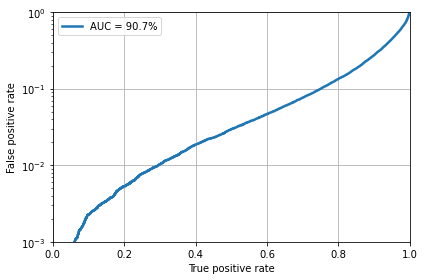

In [10]:
# reload best weights
keras_model.load_weights('keras_model_best.h5')

# run model inference on test data set
predict_array_test = keras_model.predict(feature_array_test)

# create ROC curve
fpr, tpr, threshold = roc_curve(label_array_test[:,1], predict_array_test[:,1])
    
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('ROC.png')
plt.savefig('ROC.pdf')